## Beginner's Guide to Customer Segmentation

I am going through the Beginner's Guide to Customer Segmentation that was posted on [yhat.com.](http://blog.yhat.com/posts/customer-segmentation-python-rodeo.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as ply
%matplotlib inline

In [2]:
df_offers = pd.read_excel('./WineKMC.xlsx', sheetname = 0)
df_offers.columns =['offer_id', 'campaign', 'varietal', 'min_qty', 'discount', 'origin',
                   'past_peak']
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [3]:
df_transactions = pd.read_excel('./WineKMC.xlsx', sheetname = 1)
df_transactions.columns = ['customer_name', 'offer_id']
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [4]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)

In [5]:
# create a 'pivot table' which will give us the number of times each customer responded to a 
# given off
matrix = df.pivot_table(index=['customer_name'], columns = ['offer_id'], 
                       values = 'n')

In [6]:
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [7]:
# a little tidying - fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()

In [8]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# save a lis0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]

In [15]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)

# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[x_cols])
matrix.cluster.value_counts()

1    42
3    28
2    15
0    11
4     4
Name: cluster, dtype: int64

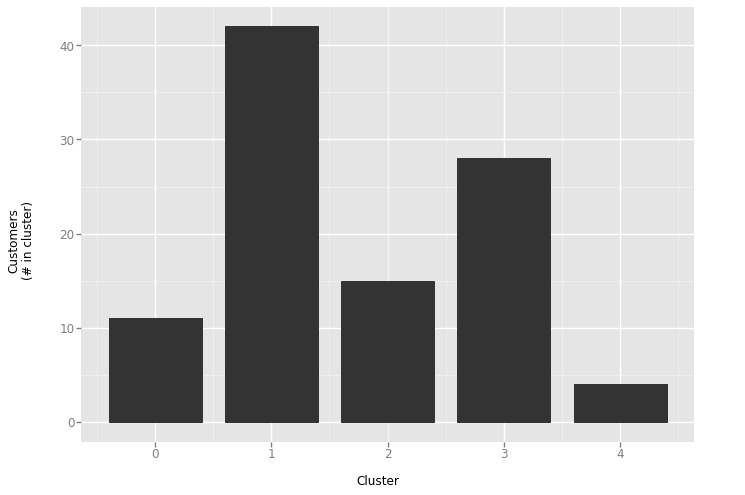

<ggplot: (293775237)>

In [18]:
from ggplot import *
ggplot(matrix, aes(x='factor(cluster)')) + geom_bar() + xlab("Cluster") + \
ylab("Customers\n(# in cluster)")

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,0,-1.007580,0.108215
1,Allen,1,0.287539,0.044715
2,Anderson,4,0.392032,1.038391
3,Bailey,0,-0.699477,-0.022542
4,Baker,1,-0.088183,-0.471695


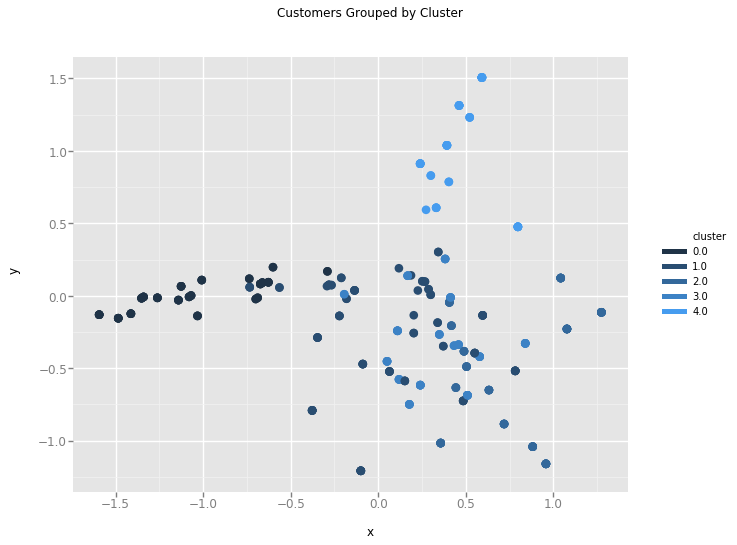

<ggplot: (272342585)>

In [19]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)


ggplot(df, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")

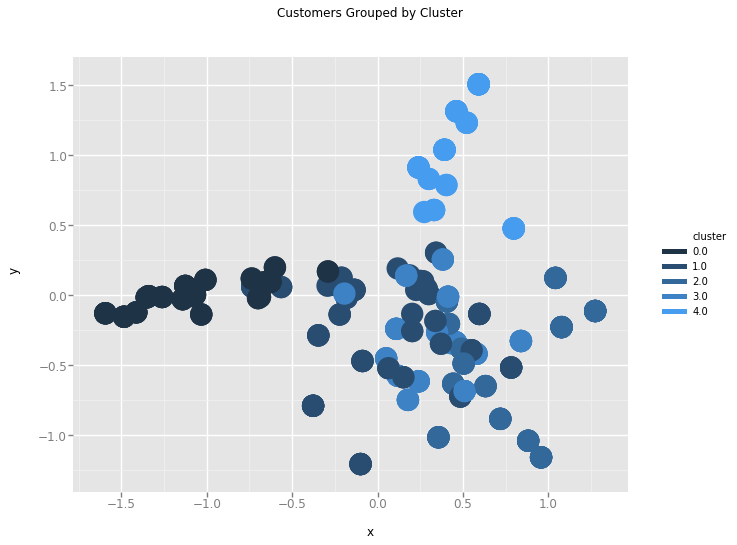

<ggplot: (293731601)>

In [21]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

ggplot(df, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    geom_point(cluster_centers, size=500) +\
    ggtitle("Customers Grouped by Cluster")

In [23]:
df['is_4'] = df.cluster==4
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Champagne             80
       Prosecco              41
       Espumante             40
       Cabernet Sauvignon    32
       Malbec                31
       Merlot                19
       Pinot Grigio          17
       Chardonnay            14
       Pinot Noir             7
True   Pinot Noir            37
       Prosecco               2
       Champagne              1
       Chardonnay             1
       Malbec                 1
       Merlot                 1
Name: varietal, dtype: int64